In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

ModuleNotFoundError: No module named 'google'

# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [6]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.322833
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in* 



In [7]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 3.292500 analytic: 3.292500, relative error: 1.670378e-08
numerical: 1.336041 analytic: 1.336041, relative error: 3.106650e-08
numerical: 1.671648 analytic: 1.671648, relative error: 8.834643e-10
numerical: -2.054014 analytic: -2.054014, relative error: 4.506260e-08
numerical: 1.082679 analytic: 1.082679, relative error: 5.261048e-08
numerical: 1.686170 analytic: 1.686170, relative error: 1.043347e-10
numerical: 0.114194 analytic: 0.114194, relative error: 1.757135e-07
numerical: 0.117740 analytic: 0.117740, relative error: 2.611914e-07
numerical: 2.078556 analytic: 2.078556, relative error: 1.008565e-08
numerical: -0.574058 analytic: -0.574058, relative error: 1.540916e-07
numerical: -2.464629 analytic: -2.464629, relative error: 6.676301e-09
numerical: -0.650050 analytic: -0.650050, relative error: 1.032756e-07
numerical: 0.630697 analytic: 0.630697, relative error: 2.697877e-08
numerical: -3.211711 analytic: -3.211711, relative error: 6.161730e-09
numerical: 1.573389 anal

In [9]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.322833e+00 computed in 0.290277s
vectorized loss: 2.322833e+00 computed in 0.007740s
Loss difference: 0.000000
Gradient difference: 0.000000


In [15]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from tqdm import tqdm
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [2e-8, 5e-7]
regularization_strengths = [2.5e4, 5e4]
lr_range = np.linspace(learning_rates[0], learning_rates[1], 8)
reg_range = np.linspace(regularization_strengths[0], regularization_strengths[1], 8)
# 定义损失函数训练的模型
softmax = Softmax()
tic = time.time()

for lr in tqdm(lr_range):
    for reg in reg_range:
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=500, verbose=False)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        acc_train = np.mean(y_train == y_train_pred)
        acc_val = np.mean(y_val == y_val_pred)
        # load result into results
        results[(lr, reg)] = (acc_train, acc_val)
        if acc_val > best_val:
            best_val = acc_val
            best_softmax = softmax
        # Print out results.
        print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
            lr, reg, acc_train, acc_val))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

lr 2.000000e-08 reg 2.500000e+04 train accuracy: 0.180816 val accuracy: 0.175000
lr 2.000000e-08 reg 2.857143e+04 train accuracy: 0.218898 val accuracy: 0.206000
lr 2.000000e-08 reg 3.214286e+04 train accuracy: 0.263122 val accuracy: 0.263000
lr 2.000000e-08 reg 3.571429e+04 train accuracy: 0.296163 val accuracy: 0.312000
lr 2.000000e-08 reg 3.928571e+04 train accuracy: 0.312898 val accuracy: 0.332000
lr 2.000000e-08 reg 4.285714e+04 train accuracy: 0.314184 val accuracy: 0.324000
lr 2.000000e-08 reg 4.642857e+04 train accuracy: 0.309082 val accuracy: 0.332000


 12%|██████████▌                                                                         | 1/8 [00:37<04:21, 37.33s/it]

lr 2.000000e-08 reg 5.000000e+04 train accuracy: 0.308694 val accuracy: 0.332000
lr 8.857143e-08 reg 2.500000e+04 train accuracy: 0.333122 val accuracy: 0.348000
lr 8.857143e-08 reg 2.857143e+04 train accuracy: 0.324612 val accuracy: 0.336000
lr 8.857143e-08 reg 3.214286e+04 train accuracy: 0.325653 val accuracy: 0.348000
lr 8.857143e-08 reg 3.571429e+04 train accuracy: 0.313061 val accuracy: 0.331000
lr 8.857143e-08 reg 3.928571e+04 train accuracy: 0.317184 val accuracy: 0.330000
lr 8.857143e-08 reg 4.285714e+04 train accuracy: 0.314571 val accuracy: 0.321000
lr 8.857143e-08 reg 4.642857e+04 train accuracy: 0.315347 val accuracy: 0.328000


 25%|█████████████████████                                                               | 2/8 [00:54<02:34, 25.74s/it]

lr 8.857143e-08 reg 5.000000e+04 train accuracy: 0.307082 val accuracy: 0.330000
lr 1.571429e-07 reg 2.500000e+04 train accuracy: 0.337694 val accuracy: 0.353000
lr 1.571429e-07 reg 2.857143e+04 train accuracy: 0.323102 val accuracy: 0.332000
lr 1.571429e-07 reg 3.214286e+04 train accuracy: 0.328653 val accuracy: 0.337000
lr 1.571429e-07 reg 3.571429e+04 train accuracy: 0.316633 val accuracy: 0.331000
lr 1.571429e-07 reg 3.928571e+04 train accuracy: 0.316551 val accuracy: 0.331000
lr 1.571429e-07 reg 4.285714e+04 train accuracy: 0.314306 val accuracy: 0.333000
lr 1.571429e-07 reg 4.642857e+04 train accuracy: 0.321306 val accuracy: 0.330000


 38%|███████████████████████████████▌                                                    | 3/8 [01:08<01:41, 20.36s/it]

lr 1.571429e-07 reg 5.000000e+04 train accuracy: 0.306245 val accuracy: 0.311000
lr 2.257143e-07 reg 2.500000e+04 train accuracy: 0.328449 val accuracy: 0.339000
lr 2.257143e-07 reg 2.857143e+04 train accuracy: 0.329735 val accuracy: 0.340000
lr 2.257143e-07 reg 3.214286e+04 train accuracy: 0.323204 val accuracy: 0.338000
lr 2.257143e-07 reg 3.571429e+04 train accuracy: 0.316633 val accuracy: 0.341000
lr 2.257143e-07 reg 3.928571e+04 train accuracy: 0.310510 val accuracy: 0.322000
lr 2.257143e-07 reg 4.285714e+04 train accuracy: 0.313122 val accuracy: 0.332000
lr 2.257143e-07 reg 4.642857e+04 train accuracy: 0.299898 val accuracy: 0.316000


 50%|██████████████████████████████████████████                                          | 4/8 [01:22<01:10, 17.75s/it]

lr 2.257143e-07 reg 5.000000e+04 train accuracy: 0.310959 val accuracy: 0.318000
lr 2.942857e-07 reg 2.500000e+04 train accuracy: 0.327429 val accuracy: 0.333000
lr 2.942857e-07 reg 2.857143e+04 train accuracy: 0.323939 val accuracy: 0.341000
lr 2.942857e-07 reg 3.214286e+04 train accuracy: 0.319918 val accuracy: 0.331000
lr 2.942857e-07 reg 3.571429e+04 train accuracy: 0.305837 val accuracy: 0.311000
lr 2.942857e-07 reg 3.928571e+04 train accuracy: 0.308959 val accuracy: 0.336000
lr 2.942857e-07 reg 4.285714e+04 train accuracy: 0.297551 val accuracy: 0.327000
lr 2.942857e-07 reg 4.642857e+04 train accuracy: 0.309347 val accuracy: 0.325000


 62%|████████████████████████████████████████████████████▌                               | 5/8 [01:36<00:49, 16.36s/it]

lr 2.942857e-07 reg 5.000000e+04 train accuracy: 0.307245 val accuracy: 0.326000
lr 3.628571e-07 reg 2.500000e+04 train accuracy: 0.325878 val accuracy: 0.340000
lr 3.628571e-07 reg 2.857143e+04 train accuracy: 0.321408 val accuracy: 0.335000
lr 3.628571e-07 reg 3.214286e+04 train accuracy: 0.314429 val accuracy: 0.323000
lr 3.628571e-07 reg 3.571429e+04 train accuracy: 0.307633 val accuracy: 0.319000
lr 3.628571e-07 reg 3.928571e+04 train accuracy: 0.307959 val accuracy: 0.324000
lr 3.628571e-07 reg 4.285714e+04 train accuracy: 0.308776 val accuracy: 0.340000
lr 3.628571e-07 reg 4.642857e+04 train accuracy: 0.314367 val accuracy: 0.328000


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [01:50<00:31, 15.58s/it]

lr 3.628571e-07 reg 5.000000e+04 train accuracy: 0.309776 val accuracy: 0.325000
lr 4.314286e-07 reg 2.500000e+04 train accuracy: 0.332041 val accuracy: 0.339000
lr 4.314286e-07 reg 2.857143e+04 train accuracy: 0.320429 val accuracy: 0.335000
lr 4.314286e-07 reg 3.214286e+04 train accuracy: 0.324592 val accuracy: 0.328000
lr 4.314286e-07 reg 3.571429e+04 train accuracy: 0.312204 val accuracy: 0.331000
lr 4.314286e-07 reg 3.928571e+04 train accuracy: 0.307980 val accuracy: 0.323000
lr 4.314286e-07 reg 4.285714e+04 train accuracy: 0.317510 val accuracy: 0.325000
lr 4.314286e-07 reg 4.642857e+04 train accuracy: 0.300633 val accuracy: 0.323000


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [02:16<00:18, 18.80s/it]

lr 4.314286e-07 reg 5.000000e+04 train accuracy: 0.298633 val accuracy: 0.298000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.331612 val accuracy: 0.346000
lr 5.000000e-07 reg 2.857143e+04 train accuracy: 0.318082 val accuracy: 0.338000
lr 5.000000e-07 reg 3.214286e+04 train accuracy: 0.317878 val accuracy: 0.335000
lr 5.000000e-07 reg 3.571429e+04 train accuracy: 0.315980 val accuracy: 0.325000
lr 5.000000e-07 reg 3.928571e+04 train accuracy: 0.301388 val accuracy: 0.316000
lr 5.000000e-07 reg 4.285714e+04 train accuracy: 0.298816 val accuracy: 0.311000
lr 5.000000e-07 reg 4.642857e+04 train accuracy: 0.303694 val accuracy: 0.319000


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:55<00:00, 21.94s/it]

lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.310612 val accuracy: 0.310000
best validation accuracy achieved during cross-validation: 0.353000


In [16]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.329000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



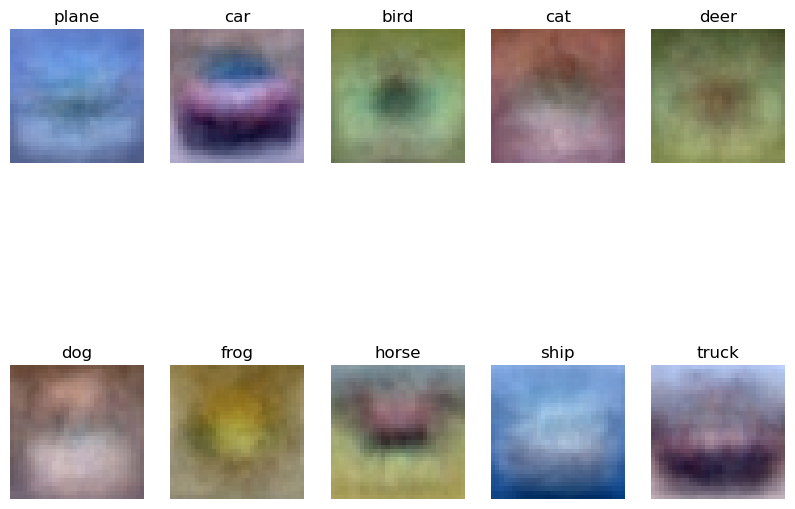

In [17]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])